In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
%pwd

'/Users/hhi/New_Programming/dacon/bycicle'

# 데이터 받기 전 생각

데이터에는, 일별 온도, 습도, 강수량 등 일기 예보 데이터를 통해서 따릉이 대여량을 예측하는 것이다. 
(날짜(일), 풍향, 하늘 상태, 강수 형태, 풍속, 습도, 최저 기온, 최고 기온, 강수 확률,)(따릉이 대여량) 


- 내 생각에는, 다양한 데이터를 통해서 새로운 칼럼을 생성해서 학습을 시켜야된다고 생각이 듦. 
예를들면, 최고 기온과 최저 기온을 생각해보자면, 사람들이 따릉이를 대여하는 시간 자체는 낮시간일 것으로 유추가 됨. -> 평균 기온을 통해서 어떻게 하면 되지 않을까 생각이 드는데.... 정확하게는 모르겠지만 대충 그런 생각이 듦. 

- 비오는 날
비오는 날에는 아무래도 대여를 많이 안하겠지뭐... 강수 형태가 중요하다고 생각이 든다. 강수형태가 어떻게 되어있는지에 따라서... 대여 량도 많이 변할거 같은데. 

- 공휴일
공휴일에 따릉이를 타는 사람이 많아 질 것으로 예상이 된다. 주말에도 많아 질 것 같은데, 이건 아마도... 반복되는 패턴이 있기 때문에 알아서 패턴을 이해하지 않을까 싶음. 



# 기상 데이터는 하루에 총 8번, 3시간 간격으로 발표되는 기상 단기 예보 데이터를 1 일 평규능로 변환한 데이터 입니다. 

## sky_condition : 하늘 상태, 
### 1 : 맑음 3 : 구름 많음, 4: 흐림


## precipitation_form : 강수 형태, 
### 0 : 없음, 1.  비, 2 : 진눈깨비, 3 : 눈, 4 : 소나기
ex) 0.5 인 경우, 하루의 절반은 비가 올 것으로 예측하고, 나머지 절반은 맑을 것으로 예측했다. 라는 의미로 해석하면됨. 

In [5]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sub = pd.read_csv('sample_submission.csv')
# train.drop(['id'], axis = 1, inplace = True)

# test data set : 2021-04-01 ~ 2021-06-30

In [11]:
test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


# train data set : 2018-04-01 ~ 2020-06-30

In [7]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [8]:
sub.head()

,date_time,number_of_rentals
0,2021-04-01,0
1,2021-04-02,0
2,2021-04-03,0
3,2021-04-04,0
4,2021-04-05,0


In [15]:
train.describe()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,202.750967,2.288256,0.100963,2.480963,56.745491,13.795249,23.384733,16.878103,59574.978022
std,56.659232,0.961775,0.203193,0.884397,12.351268,5.107711,5.204605,16.643772,27659.575774
min,57.047000,1.000000,0.000000,0.753000,24.831000,1.938000,9.895000,0.000000,1037.000000
25%,171.541000,1.405000,0.000000,1.820000,47.196000,9.938000,19.842000,4.054000,36761.000000
50%,209.774000,2.167000,0.000000,2.411000,55.845000,14.375000,24.158000,12.162000,63032.000000
75%,238.412000,3.000000,0.088000,2.924000,66.419000,18.000000,27.526000,22.973000,81515.000000
max,321.622000,4.000000,1.000000,5.607000,88.885000,22.312000,33.421000,82.162000,110377.000000


### date_time 이 문자열로 취급되어 제대로 된 분석이 불가능하다고 함. 
-> 분석하기 쉽도록 각각 년, 월, 일로 나누는 과정

In [16]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5


In [18]:
data_description = train.describe()
data_description

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,202.750967,2.288256,0.100963,2.480963,56.745491,13.795249,23.384733,16.878103,59574.978022,2019.000000,5.000000,15.670330
std,56.659232,0.961775,0.203193,0.884397,12.351268,5.107711,5.204605,16.643772,27659.575774,0.817996,0.813489,8.774195
min,57.047000,1.000000,0.000000,0.753000,24.831000,1.938000,9.895000,0.000000,1037.000000,2018.000000,4.000000,1.000000
25%,171.541000,1.405000,0.000000,1.820000,47.196000,9.938000,19.842000,4.054000,36761.000000,2018.000000,4.000000,8.000000
50%,209.774000,2.167000,0.000000,2.411000,55.845000,14.375000,24.158000,12.162000,63032.000000,2019.000000,5.000000,16.000000
75%,238.412000,3.000000,0.088000,2.924000,66.419000,18.000000,27.526000,22.973000,81515.000000,2020.000000,6.000000,23.000000
max,321.622000,4.000000,1.000000,5.607000,88.885000,22.312000,33.421000,82.162000,110377.000000,2020.000000,6.000000,31.000000


### data 가 어떻게 구성이 되어있는지 히스토그램으로 표현하는 과정. 
-> 신기한 점은, data_description 을 통해서 평균 값을 구하는 과정이 포함 되어있다. 

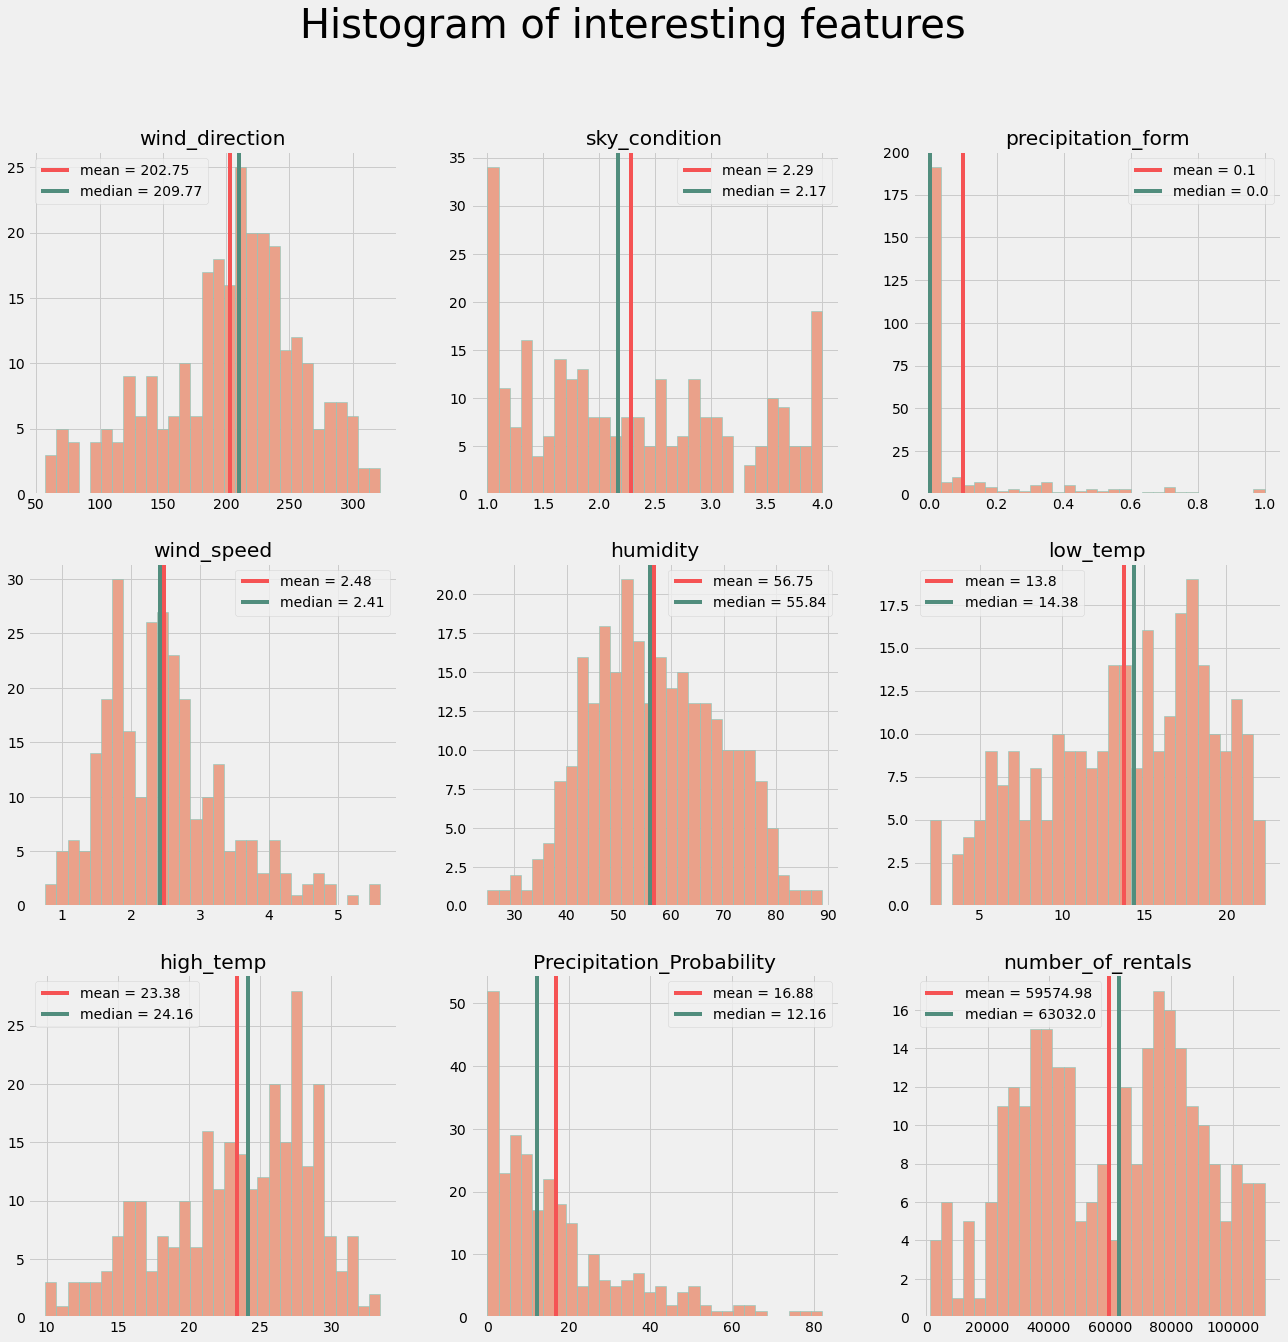

In [19]:
interest_coloumns = ['wind_direction', 'sky_condition', 'precipitation_form', 'wind_speed', 'humidity', 'low_temp', 'high_temp', 'Precipitation_Probability', 'number_of_rentals']

plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(3, 3, figsize = (20, 20))
fig.suptitle('Histogram of interesting features', fontsize=40)

column_idx = 0
for i in range(3):
    for j in range(3):
        ax[i][j].hist(train[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1


### 요일 데이터가 없는 상황이다. 요일 데이터를 넣도록 하자 . 


In [20]:
week_day = pd.to_datetime(train['date_time']).dt.day_name()
train['week_day'] = week_day
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week_day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,Sunday
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,Monday
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,Tuesday
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,Wednesday
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,Thursday


# EDA 를 해보자. 

## 공휴일을 생각해야됨을 계속해서 인지하고 있자! 

### 상관분석은 숫자로 계산할 수 있으므로, 데이터에서 숫자로 이뤄진 칼럼만을 뽑는다고 함 ( date_time.drop) 이 되는 상황

In [25]:
train_number = train.select_dtypes(np.number)

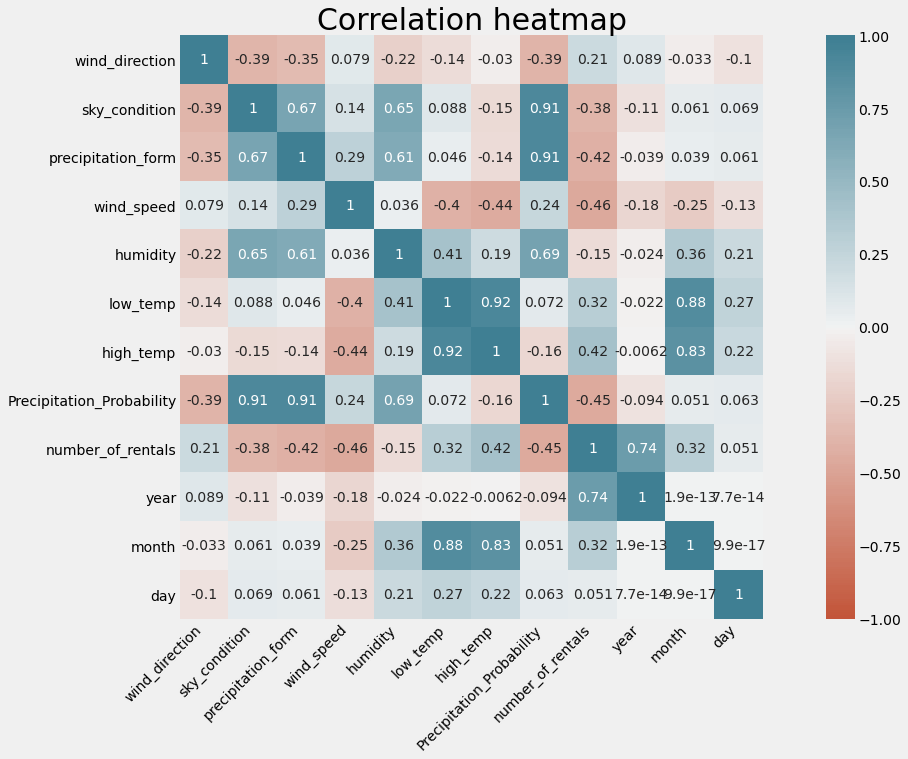

In [26]:
corr = train_number.corr()
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Correlation heatmap', fontsize=30)
plt.show()

correlation 을 보게 되면,

number_of_rentals => "wind_direction", "low_temp & high_temp", "year" 와 연관이 있음을 알 수 있다. 

- year & month & date
> 시간이 지날수록, 따릉이라는 존재를 인식하기 때문에 상관 관계 가 많은 것으로 판단. 

- temp
> 날이 좋으면 사람들이 많이 대여하고, 날이 좋지 않으면 사람들이 적게 대여함을 대충 알 수 있다. 

- wind_direction
> 어떻게 판단해야될지는 모르겠음. ㅎ 


## year, month, date 에 따른 rental 양 확인하자

In [27]:
year_rentals = train.groupby('year').sum()['number_of_rentals']
month_rentals = train.groupby('month').sum()['number_of_rentals']
day_rentals = train.groupby('day').sum()['number_of_rentals']

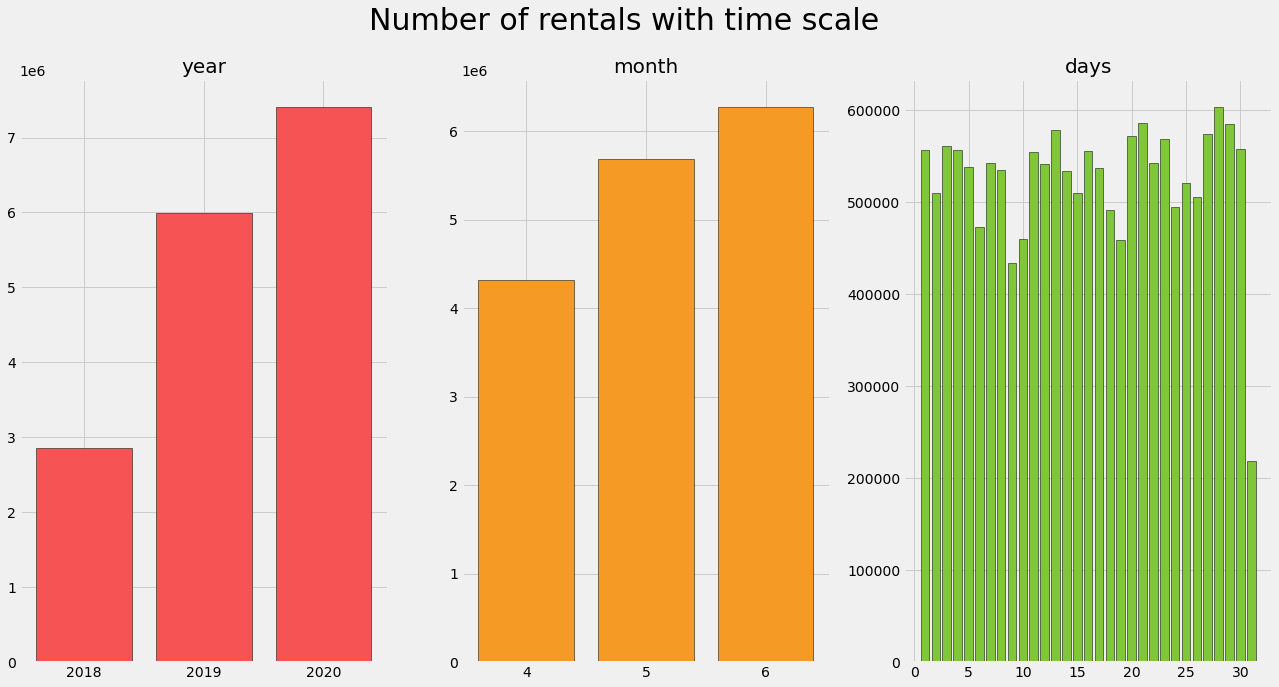

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
fig.suptitle('Number of rentals with time scale', fontsize=30)

ax[0].bar(x=['2018', '2019', '2020'], height=year_rentals, color='#f55354', edgecolor='black')
ax[0].set_title('year', fontsize = 20)

ax[1].bar(x = ['4', '5', '6'], height=month_rentals, color='#f59b25', edgecolor='black')
ax[1].set_title('month', fontsize = 20)

ax[2].bar(x=day_rentals.index.to_list(), height= day_rentals, color='#7fc638', edgecolor='black')
ax[2].set_title('days', fontsize = 20)

plt.show()

- year
해를 거듭할수록 따릉이에 대해서 알고 있는 사람이 늘어나기 때문에 대여량도 많은 것으로 판단이 된다. 
- month
날이 따뜻할수록 사람들이 많이 다닌 것으로 판단이 된다. 
- days
일은 별로 상관관계가 보이지 않는다. 


### day 에 따라서 어떻게 변화가 있는지 확인해보자

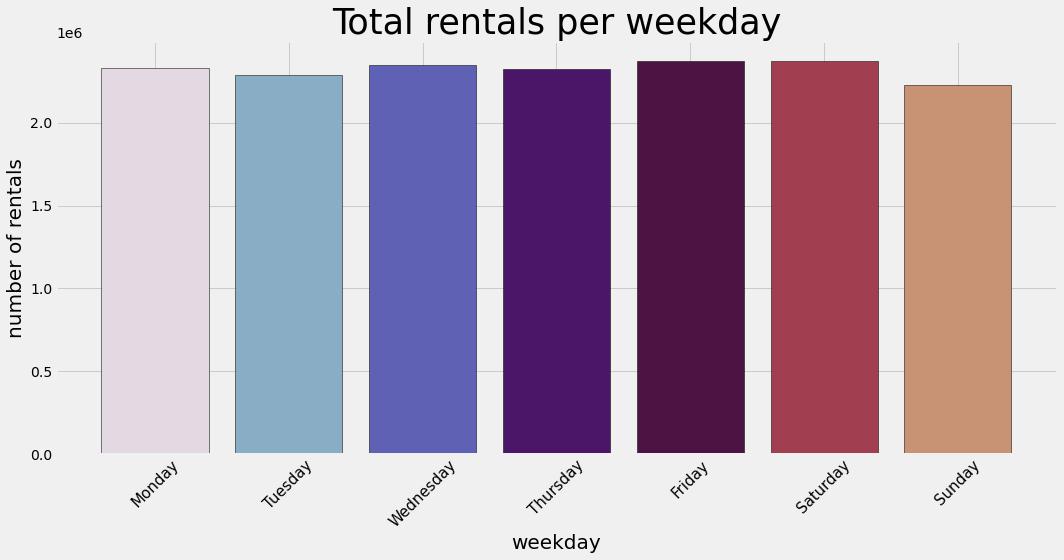

In [31]:
day_table = train.groupby('week_day').sum()
day_table = day_table.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
color_map = plt.get_cmap('twilight')
color_list = [color_map.colors[i] for i in range(0, 512, 72)]
plt.bar(day_table.index, day_table.number_of_rentals, edgecolor='black', color=color_list)
plt.xticks(rotation=45, fontsize=15)
plt.title('Total rentals per weekday', fontsize=35)
plt.xlabel('weekday', fontsize=20)
plt.ylabel('number of rentals', fontsize=20)
plt.tight_layout()
plt.show()

- 별로 관련이 없는 것으로 판단이 된다. 근데 공휴일에도 연관이 없음을 보고 좀 놀랐었음

## 강수확률, 하늘 상태 산점도

강수확률과 하늘상태는 correlation 이 상당히 높게 나왔다. 

이 두개의 상관관계를 알아보자. 

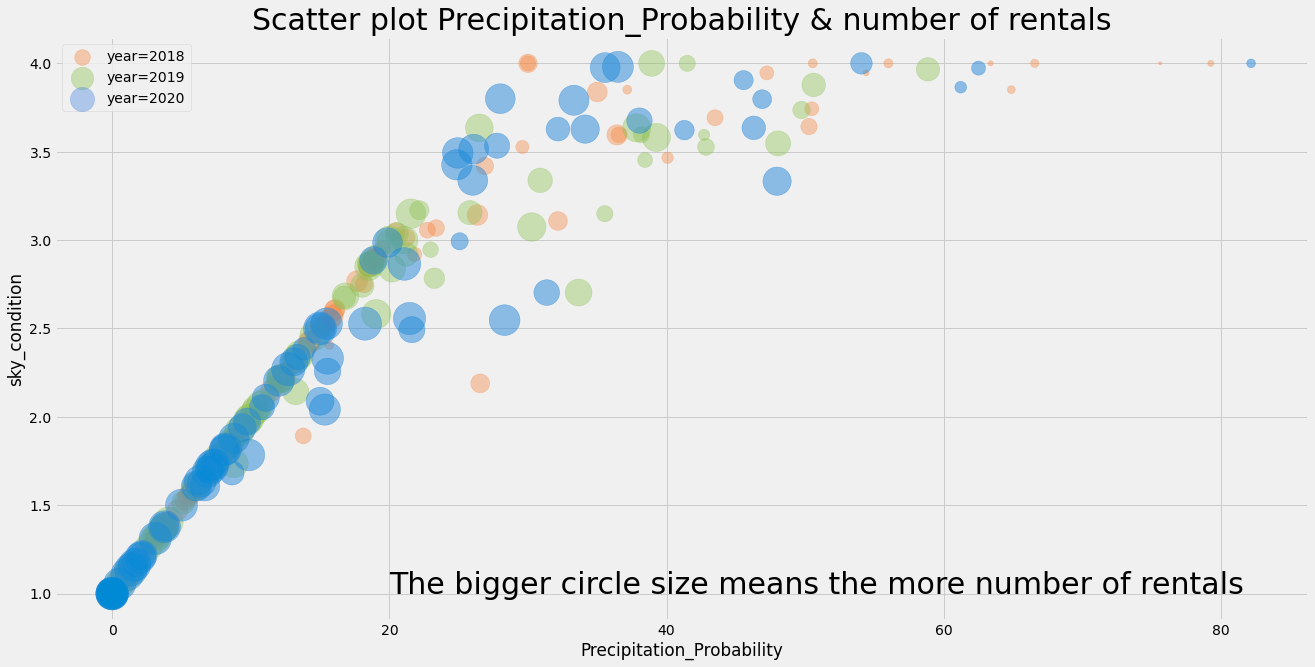

In [36]:
years = [2018,2019,2020]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize = (20,10))

for year, color in zip(years, colors):
    precipitation_prb = train[train['year'] == year].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = train[train['year'] == year].sort_values(by = 'Precipitation_Probability')['number_of_rentals']
    sky_condition = train[train['year']==year].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'year={year}')    
    
plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)            
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

강수확률이 낮을수록 , 하늘 상태의 값도 낮아짐을 알 수 있다. 

강수 확률이 높을수록 점의 크기가 작아지는 것( 대여량 이 줆) 을 알 수 있다. 

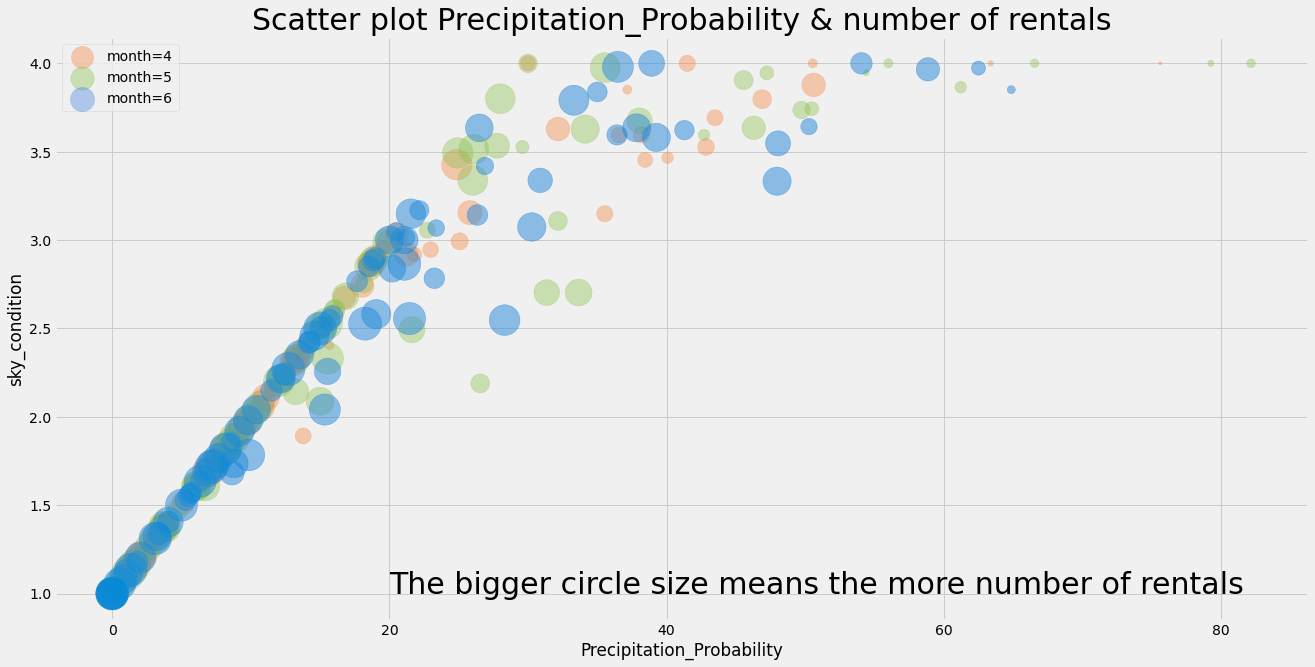

In [37]:
monthes = [4, 5, 6]
colors = ['#f68842', '#8cc152', '#4a89df']

plt.figure(figsize=(20, 10))

for month, color in zip(monthes, colors):
    
    precipitation_prb = train[train['month'] == month].sort_values(by='Precipitation_Probability')['Precipitation_Probability']
    rentals = train[train['month'] == month].sort_values(by='Precipitation_Probability')['number_of_rentals']
    sky_condition = train[train['month'] == month].sort_values(by='Precipitation_Probability')['sky_condition']
    
    plt.scatter(precipitation_prb, sky_condition, s=rentals/100, alpha=0.4, c=color, label=f'month={month}')


plt.scatter(precipitation_prb, sky_condition,s=rentals/100, alpha=0.2)
plt.title('Scatter plot Precipitation_Probability & number of rentals', fontsize=30)
plt.xlabel('Precipitation_Probability')
plt.ylabel('sky_condition')
plt.text(20, 1.0, 'The bigger circle size means the more number of rentals', fontsize= 30)
plt.legend()
plt.show()

6월달에 제일 많이 빌린 것으로 판단을 할 수 있다고 한다. 

## 온도, 습도에 대한 불쾌 지수에 대한 정보 사용해보자!!!

불쾌지수 = 1.8*기온 - 0.55(1-습도)*(1.8*기온-26)+32 로 계산이 된다고 한다. 
퍼센티지로 계산이 되기 때문에 1-습도 는 100 으로 변경해야될 것 같음
공식이 뭔가 수정이 필요하다고 판단이 된다. 

불쾌 지수가 80 이 넘어가면 사람들이 불쾌감을 느낀다고 한다. 

### 일단은 단순하게 하루의 평균 기온을 생성하긴 했다. 
이를 통해서 불쾌 지수에 대한 feature 를 새롭게 생성하였다

In [48]:
train['Temperature'] =(train['low_temp']+train['high_temp'])/2
train['Feeling'] = (5/9)*train['Temperature']-0.55*((100-train['humidity'])/100)*((5/9)*train['Temperature']-26)+32
# train['Feeling?'] = (1.8)*train['Temperature']-0.55*((100-train['humidity'])/100)*(1.8*train['Temperature']-26)+32

In [49]:
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,week_day,Temperature,Feeling,Feeling?
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,Sunday,16.800,43.625000,61.657000
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,Monday,15.906,43.684381,60.194302
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,Tuesday,12.814,41.727607,55.470688
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,Wednesday,10.340,40.880622,51.755888
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,Thursday,8.148,39.622864,48.300569


In [50]:
train_number = train.select_dtypes(np.number)

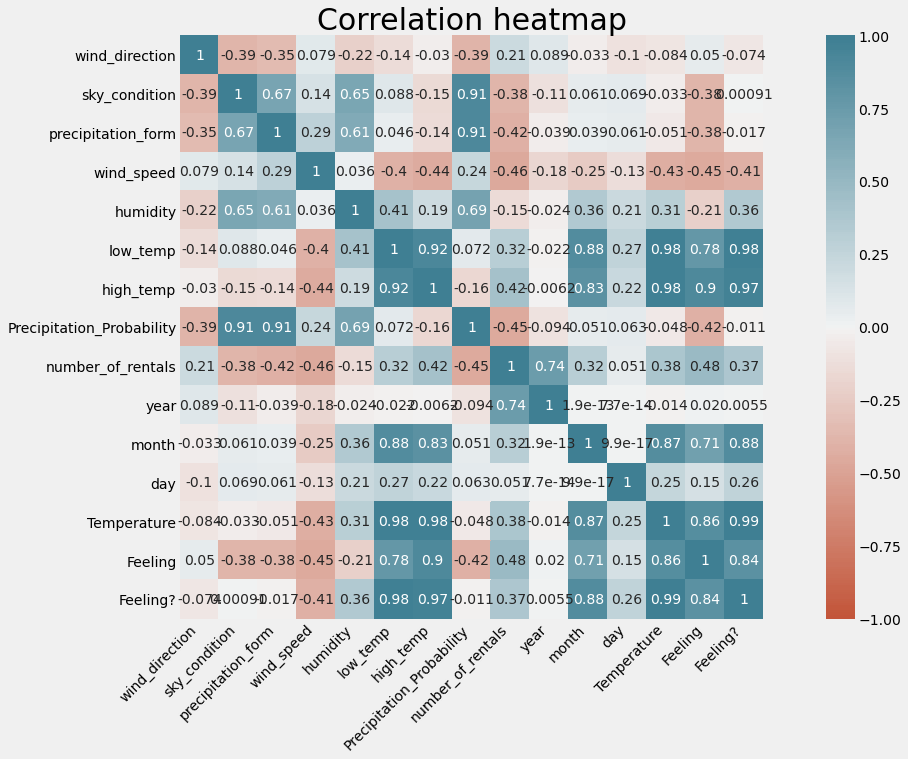

In [51]:
corr = train_number.corr()
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.title('Correlation heatmap', fontsize=30)
plt.show()